# Simulating a Hodgkin–Huxley neuron with ``braincell``

This section introduces how to simulate Hodgkin-Huxley neurons using `braincell`.

## Overview of the HH Model

Alan Hodgkin (1914–1998) and Andrew Huxley (1917–2012) were the first to describe the mechanism underlying the generation of action potentials. Around 1950, through a series of experiments, they elucidated the ionic basis of action potentials and were awarded the Nobel Prize in Physiology or Medicine in 1963 for their work. The Hodgkin-Huxley (HH) model is the first mathematical model to accurately describe the process of action potential generation in neurons.

For an HH-type neuron, we mainly focus on its cell membrane. The neuronal membrane is a phospholipid bilayer that separates the intracellular and extracellular environments. In the aqueous environments inside and outside the cell, water-soluble charged molecules, such as ions and neurotransmitters, cannot passively cross the phospholipid bilayer and thus require transport proteins to move from one side to the other. Ion channels are a type of transmembrane transport protein.

Some ion channels are gated, meaning they can open or close in response to electrical, chemical, or physical stimuli. In simple terms, each type of gated channel allows the corresponding ion to pass through—sodium channels allow Na⁺ ions, potassium channels allow K⁺ ions, and so on.

Other ion channels are non-gated and remain open continuously. The HH model combines these channels into a single equivalent leak current channel.

A typical structure of an HH-type neuronal membrane is shown below:

![Hierarchical Structure](_static/image/braincell_HH_neuron_structure-en.png)

Summary of the HH neuron mechanism:

* Neurons are surrounded by a cell membrane that contains various ion channels
* Ion channels control the flow of ions in and out of the cell
* Ion flow induces changes in the membrane potential, which drives neuronal activity

To describe changes in membrane potential and the generation of action potentials, an effective approach is to construct an equivalent electrical circuit of the neuron.
Typically, this circuit model consists of three components:

* Resistors representing ion channels
* Voltage sources representing ionic concentration gradients
* Capacitors representing the membrane’s ability to store charge

The correspondence between neuronal components and equivalent circuit elements is illustrated below:

![Equivalent Circuit Components](_static/image/braincell_HH_neuron_part-en.png)

The membrane capacitance is denoted by $C_m$, and an ion channel can be modeled as a circuit element containing a resistor $R_X$ and a voltage source $E_X$.
Since resistance is the inverse of conductance, the conductance of an ion channel is $g_X = 1 / R_X$, where $X$ represents different ions such as $Na$ or $K$.

Combining these elements, the HH model’s equivalent circuit is shown below:

![Equivalent Circuit](_static/image/braincell_HH_neuron_circuit.png)

The relationship between the charge stored in the capacitor $q$ and the membrane potential $V_m$ is given by $q = C_m V_m$.

With this foundation, we can now proceed to model HH-type neurons.


## Ion Channel Modeling

As mentioned above, the electrical properties of HH-type neurons are mainly controlled by ion channels. Therefore, to accurately model a neuron or even a network, it is essential to first understand how to model ion channels.

In the HH model, each ion channel is considered a transmembrane protein forming a pore through which ions can diffuse along their concentration gradient. These pores contain multiple gates that can open or close, and the probability of each gate being open or closed depends on the membrane potential.

For each gate, let $\alpha(V)$ and $\beta(V)$ be the voltage-dependent rates for the gate to transition from closed to open and from open to closed, respectively. Let $m$ be the fraction of gates that are open, and $1 - m$ the fraction that are closed. Then we have:

$$
\frac{dm}{dt} = \alpha(V)(1 - m) - \beta(V)m
$$

$$
= \frac{m_{\infty}(V) - m}{\tau(V)},
$$

where

$$
m_{\infty}(V) = \frac{\alpha(V)}{\alpha(V) + \beta(V)}, \quad \tau(V) = \frac{1}{\alpha(V) + \beta(V)}.
$$

In the HH model, the parameters $\alpha$ and $\beta$ in $m_{\infty}(V)$ and $\tau(V)$ can be fitted based on experimental data.

Gates can be classified as activation gates or inactivation gates. Different ion channels have different types and numbers of gates. For example, a typical sodium channel is described as:

$$
g_{\text{Na}} = \bar{g}_{\text{Na}} m^3 h,
$$

where $\bar{g}_{\text{Na}}$ is the maximum conductance of the sodium channel, $m \in [0, 1]$ is the activation gate variable, and $h \in [0, 1]$ is the inactivation gate variable. Both $m$ and $h$ follow first-order kinetics. The term $m^3 h$ indicates that the sodium channel has three independent activation gates and one independent inactivation gate; all gates must be open for $\text{Na}^+$ to pass through.

In contrast, a typical potassium channel only has activation gates and no inactivation gates, while leak channels have neither type of gate.

In the `braincell` framework, ion channel modeling is primarily based on these principles.

For a typical sodium channel, the mathematical form is:

$$
\begin{aligned}
g_{\mathrm{Na}} &= g_{\mathrm{max}} \cdot p^3 \cdot q \\
\frac{dp}{dt} &= \phi \left( \alpha_p (1-p) - \beta_p p \right) \\
\frac{dq}{dt} &= \phi \left( \alpha_q (1-q) - \beta_q q \right)
\end{aligned}
$$

where $\phi$ is the temperature coefficient.

Modeling this channel proceeds as follows:

In [9]:
from typing import Union, Callable, Optional

import braincell
import brainstate
import brainunit as u

from braincell.channel import SodiumChannel
from braincell import IonInfo, DiffEqState

In [10]:
class INa_p3q_markov(SodiumChannel):
    def __init__(
        self,
        size: brainstate.typing.Size,
        g_max: Union[brainstate.typing.ArrayLike, Callable] = 90. * (u.mS / u.cm ** 2),
        phi: Union[brainstate.typing.ArrayLike, Callable] = 1.,
        name: Optional[str] = None,
    ):
        super().__init__(size=size, name=name, )

        # parameters
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)

    def init_state(self, V, Na: IonInfo, batch_size=None):
        self.p = DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))
        self.q = DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, Na: IonInfo, batch_size=None):
        alpha = self.f_p_alpha(V)
        beta = self.f_p_beta(V)
        self.p.value = alpha / (alpha + beta)
        alpha = self.f_q_alpha(V)
        beta = self.f_q_beta(V)
        self.q.value = alpha / (alpha + beta)

    def compute_derivative(self, V, Na: IonInfo):
        p = self.p.value
        q = self.q.value
        self.p.derivative = self.phi * (self.f_p_alpha(V) * (1. - p) - self.f_p_beta(V) * p) / u.ms
        self.q.derivative = self.phi * (self.f_q_alpha(V) * (1. - q) - self.f_q_beta(V) * q) / u.ms

    def current(self, V, Na: IonInfo):
        return self.g_max * self.p.value ** 3 * self.q.value * (Na.E - V)

    def f_p_alpha(self, V):
        raise NotImplementedError

    def f_p_beta(self, V):
        raise NotImplementedError

    def f_q_alpha(self, V):
        raise NotImplementedError

    def f_q_beta(self, V):
        raise NotImplementedError

By observing the code above, it is clear that the `braincell` framework provides a straightforward way to model ion channels.

* `init_state` creates the necessary state variables
* `reset_state` constructs the gate equations
* `compute_derivative` computes derivatives for updating
* `current` calculates the current generated by the channel

The temperature coefficient $\phi$ is also an important parameter. Ion channels are highly sensitive to temperature, and the rates of gate opening and closing have an exponential dependence on temperature. Higher temperatures result in faster transitions between open and closed states. This aspect will not be discussed further here.

Overall, modeling ion channels with different types and numbers of gates is very convenient. For these various channels, `init_state`, `reset_state`, and `compute_derivative` are quite similar; the main difference lies in the mathematical form of `current`.

Once a sodium channel with three activation gates and one inactivation gate is established, the channel parameters can be set according to the specific model being implemented.

For example, a sodium channel described in a 1991 study has the following mathematical form:

$$
\begin{split}
\begin{aligned}
  g_{\mathrm{Na}} &= g_{\mathrm{max}} m^3 h \\
  \frac {dm} {dt} &= \phi\left(\alpha_m (1-m) - \beta_m m\right) \\
  &\alpha_m(V) = 0.32 \frac{13 - V + V_{\text{sh}}}{\exp\left(\frac{13 - V + V_{\text{sh}}}{4}\right) - 1}  \\
  &\beta_m(V) = 0.28 \frac{V - V_{\text{sh}} - 40}{\exp\left(\frac{V - V_{\text{sh}} - 40}{5}\right) - 1}  \\
  \frac {dh} {dt} &= \phi\left(\alpha_h (1-h) - \beta_h h\right) \\
  &\alpha_h(V) = 0.128 \cdot \exp\left(\frac{17 - V + V_{\text{sh}}}{18}\right)  \\
  &\beta_h(V) = \frac{4}{1 + \exp\left(-\frac{V - V_{\text{sh}} - 40}{5}\right)} \\
\end{aligned}
\end{split}
$$

Here, $V_{\text{sh}}$ is the membrane potential offset (−63 mV in the study), and $\phi$ is the temperature coefficient (default value 1 in the study).

Modeling this channel proceeds as follows:

In [11]:
class INa_TM1991(INa_p3q_markov):
    def __init__(
        self,
        size: brainstate.typing.Size,
        g_max: Union[brainstate.typing.ArrayLike, Callable] = 120. * (u.mS / u.cm ** 2),
        phi: Union[brainstate.typing.ArrayLike, Callable] = 1.,
        V_sh: Union[brainstate.typing.ArrayLike, Callable] = -63. * u.mV,
        name: Optional[str] = None,
    ):
        super().__init__(
            size,
            name=name,
            phi=phi,
            g_max=g_max,
        )
        self.V_sh = brainstate.init.param(V_sh, self.varshape, allow_none=False)

    def f_p_alpha(self, V):
        V = (self.V_sh - V).to_decimal(u.mV)
        temp = 13 + V
        return 0.32 * 4 / u.math.exprel(temp / 4)

    def f_p_beta(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        temp = V - 40
        return 0.28 * 5 / u.math.exprel(temp / 5)

    def f_q_alpha(self, V):
        V = (- V + self.V_sh).to_decimal(u.mV)
        return 0.128 * u.math.exp((17 + V) / 18)

    def f_q_beta(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 4. / (1 + u.math.exp(-(V - 40) / 5))

By examining the code above, it is clear that performing fine-grained modeling on top of an existing sodium channel is very convenient—one only needs to incorporate the corresponding mathematical expressions.

Of course, in addition to customizing specific ion channels, you can also use the channels already built into `braincell`. These channels can be directly imported when modeling neurons.

## Neuron Modeling

After modeling the ion channels, we can easily construct a single neuron model.
It is only necessary to import the corresponding ions and channels into the neuron model and set the parameters.

For example, for a classic HH-type neuron, the modeling proceeds as follows:

In [12]:
class HH(braincell.SingleCompartment):
    def __init__(self, size, solver='exp_euler', V_th=-20 * u.mV):
        super().__init__(size, solver=solver, V_th=V_th, C=1 * u.uF / u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add_elem(INa=INa_TM1991(size, g_max=100. * (u.mS / u.cm ** 2), V_sh=-63. * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90 * u.mV)
        self.k.add_elem(IK=braincell.channel.IK_TM1991(size, g_max=30. * (u.mS / u.cm ** 2), V_sh=-63. * u.mV))

        self.IL = braincell.channel.IL(size,E=-60. * u.mV,g_max=5. * (u.mS / u.cm ** 2))

By observing the code above, it is clear that modeling a single neuron using `braincell` is very straightforward.

Simulation can be performed as follows:

In [13]:
# neuron
neuron = HH(1, solver='ind_exp_euler')
brainstate.nn.init_all_states(neuron)

HH(
  in_size=(1,),
  out_size=(1,),
  ion_channels={},
  C=1. * ufarad / cmeter2,
  V_th=-20 * mvolt,
  V_initializer=Uniform(
    min_val=-70 * mvolt,
    max_val=-60. * mvolt,
    rng=RandomState([3559457453 2724814077]),
    unit=Unit(10.0^0)
  ),
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  solver=<function ind_exp_euler_step at 0x00000265E4343100>,
  na=SodiumFixed(
    size=(1,),
    name=None,
    channels={
      'INa': INa_TM1991(
        size=(1,),
        name=None,
        phi=1.0,
        g_max=100. * msiemens / cmeter2,
        V_sh=-63. * mvolt,
        p=DiffEqState(
          value=ShapedArray(float32[1]),
          _derivative=None,
          _diffusion=None
        ),
        q=DiffEqState(
          value=ShapedArray(float32[1]),
          _derivative=None,
          _diffusion=None
        )
      )
    },
    _external_currents={},
    E=50. * mvolt,
    C=0.0400811 * mmolar
  ),
  k=PotassiumFixed(
    size=(1,),
    name=None,
    channels={
      'IK': IK_TM199

The `solver` parameter allows you to choose the integration method. Different integration methods are suitable for different time steps and offer varying levels of accuracy.

Similarly, `braincell` provides a variety of built-in integration methods, such as `exp_euler`, `rk3`, `rk4`, and others.

In [14]:
def step_run(t):
    with brainstate.environ.context(t=t):
        spikes = neuron.update(30 * u.uA / u.cm ** 2)
    return neuron.V.value

In [15]:
# simulation
with brainstate.environ.context(dt=0.1 * u.ms):
    times = u.math.arange(0. * u.ms, 100 * u.ms, brainstate.environ.get_dt())
    vs = brainstate.compile.for_loop(step_run, times)

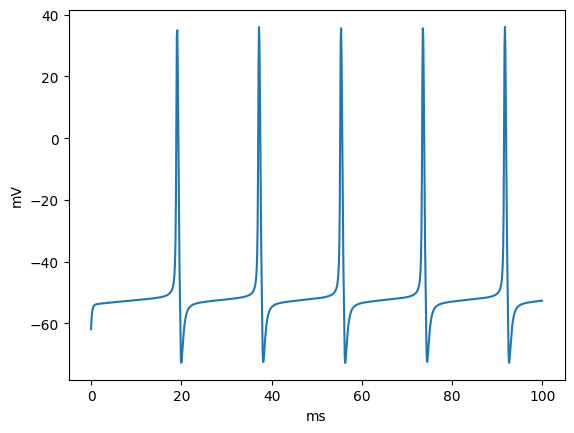

In [16]:
import matplotlib.pyplot as plt

# visualization
plt.plot(times, u.math.squeeze(vs))
plt.show()

By observing the simulation results, it is clear that the HH-type neuron we constructed generates spikes, accurately capturing its electrophysiological properties.

Of course, in addition to modeling single-compartment neurons, the `braincell` framework also supports modeling multi-compartment neurons with spatial structure, which will not be discussed further here.

The example models in this article are adapted from:

* Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies, *J. Comput. Neurosci.*, 23(3), 349–398.